<a href="https://colab.research.google.com/github/jylin04/mi-ntk/blob/main/modular_arithmetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup (run this and *'d cells at start)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import math

import numpy as np
import torch as t

from torch import nn, Tensor
from torch.nn import functional as F

from tqdm.notebook import tqdm

from typing import Tuple, Optional

In [3]:
import matplotlib.pyplot as plt

In [4]:
%pip install -q git+https://github.com/jylin04/mi-ntk.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import ntk, ma

from ma import Quadratic, Scale, ModularArithmeticMLP
from ma import build_mod_arith_data, build_mod_arith_data_symbreak, train, test
from ntk import full_jacobian, class_jacobian, empirical_ntk, empirical_ntk_by_layer, LinearisedPredictor, eig_decompose
from ntk import axis_laplacians_pxp, two_stage_axis_diagonalization

In [6]:
# cfg
epochs: int = 5000
batch_size: int = 1024
lr: float = 1e-3
n_features: int = 80
n_hidden: int = 20
sparsity: float = 0.9
importance: float = 0.9

device = t.device("cuda" if t.cuda.is_available() else "cpu")
seed = 0

t.manual_seed(seed)

# 1. Reproduce grokking results

## Train the toy model*

In [7]:
# For this slightly smaller model than the one in Gromov, the eNTK fits in T4 GPU.

class HyperParams:
  p: int = 29
  width: int = 512
  alpha: float = 0.7
  lr: float = 0.05
  epochs: int = 500
  eval_every: int = 200
  log_every: int = 10
  seed: int = 42

params = HyperParams()
t.manual_seed(params.seed)

device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [8]:
# Train/test split
X, Y, y_idx, pairs = build_mod_arith_data(params.p, device=device)
#X, Y, y_idx, pairs = build_mod_arith_data_symbreak(params.p, device=device)

perm = t.randperm(X.shape[0], device=device)
n_train = int(X.shape[0] * params.alpha)          # Put this in manually: fraction of pairs in the training vs. test set.
idx_tr, idx_te = perm[:n_train], perm[n_train:]

x_train = X[idx_tr]
y_train = Y[idx_tr]

x_test = X[idx_te]
y_test = Y[idx_te]

In [9]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size = len(x_train), shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size = len(x_test), shuffle = False)

In [10]:
model = ModularArithmeticMLP(p=params.p, n_hidden=params.width, device=device)
opt = t.optim.AdamW(model.parameters(), lr = params.lr)

In [11]:
tr_loss = []
te_loss = []
tr_acc = []
te_acc = []

for epoch in range(params.epochs):
    train_loss = train(model, train_loader, opt, device)
    if epoch % params.log_every == 0:
        tr_loss.append(train_loss)
        te_loss.append(F.mse_loss(model(x_test), y_test).item())
        acc = test(model, test_loader, device)
        tr_acc.append(test(model, train_loader, device))
        te_acc.append(acc)
        print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Accuracy {acc:.1f}")

Epoch 0: Train loss 0.0345, Accuracy 4.7
Epoch 10: Train loss 0.0331, Accuracy 0.4
Epoch 20: Train loss 0.0325, Accuracy 0.0
Epoch 30: Train loss 0.0314, Accuracy 0.0
Epoch 40: Train loss 0.0295, Accuracy 0.0
Epoch 50: Train loss 0.0256, Accuracy 0.0
Epoch 60: Train loss 0.0190, Accuracy 0.0
Epoch 70: Train loss 0.0111, Accuracy 4.0
Epoch 80: Train loss 0.0050, Accuracy 40.3
Epoch 90: Train loss 0.0023, Accuracy 80.6
Epoch 100: Train loss 0.0010, Accuracy 92.5
Epoch 110: Train loss 0.0005, Accuracy 97.2
Epoch 120: Train loss 0.0003, Accuracy 98.8
Epoch 130: Train loss 0.0001, Accuracy 99.2
Epoch 140: Train loss 0.0001, Accuracy 99.6
Epoch 150: Train loss 0.0001, Accuracy 99.6
Epoch 160: Train loss 0.0000, Accuracy 99.6
Epoch 170: Train loss 0.0000, Accuracy 99.6
Epoch 180: Train loss 0.0000, Accuracy 99.6
Epoch 190: Train loss 0.0000, Accuracy 99.6
Epoch 200: Train loss 0.0000, Accuracy 100.0
Epoch 210: Train loss 0.0000, Accuracy 100.0
Epoch 220: Train loss 0.0000, Accuracy 100.0
Epoc

In [12]:
# Uncomment iff training w/ cyclic encoding
'''for epoch in range(9500):
    train_loss = train(model, train_loader, opt, device)
    if epoch % params.log_every == 0:
        tr_loss.append(train_loss)
        te_loss.append(F.mse_loss(model(x_test), y_test).item())
        acc = test(model, test_loader, device)
        tr_acc.append(test(model, train_loader, device))
        te_acc.append(acc)
        print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Accuracy {acc:.1f}")'''

'for epoch in range(9500):\n    train_loss = train(model, train_loader, opt, device)\n    if epoch % params.log_every == 0:\n        tr_loss.append(train_loss)\n        te_loss.append(F.mse_loss(model(x_test), y_test).item())\n        acc = test(model, test_loader, device)\n        tr_acc.append(test(model, train_loader, device))\n        te_acc.append(acc)\n        print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Accuracy {acc:.1f}")'

## Plots and linear probes

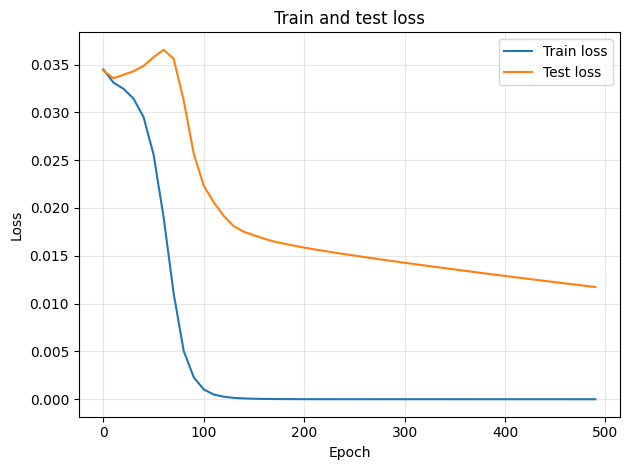

In [30]:
x_axis = np.arange(start=0, stop=params.epochs, step=params.log_every)

plt.plot(x_axis, tr_loss, label="Train loss")
plt.plot(x_axis, te_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

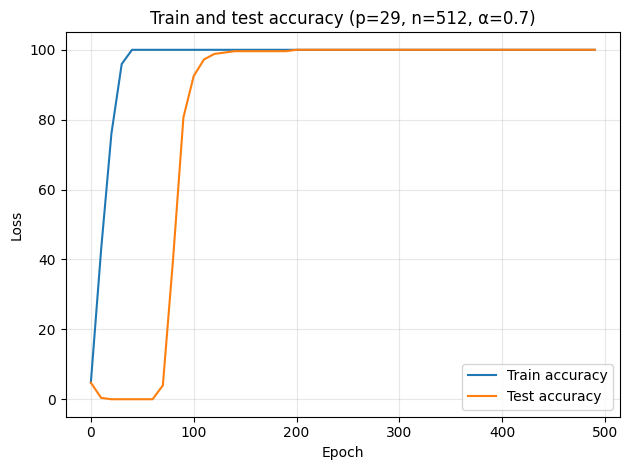

In [31]:
x_axis = np.arange(start=0, stop=params.epochs, step=params.log_every)

plt.plot(x_axis, tr_acc, label="Train accuracy")
plt.plot(x_axis, te_acc, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test accuracy (p=29, n=512, α=0.7)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-4221989810.py:16: SyntaxWarning: invalid escape sequence '\i'
  plt.xlabel('i \in 0...p-1'); plt.ylabel('j \in 0...p-1')
/tmp/ipython-input-4221989810.py:16: SyntaxWarning: invalid escape sequence '\i'
  plt.xlabel('i \in 0...p-1'); plt.ylabel('j \in 0...p-1')


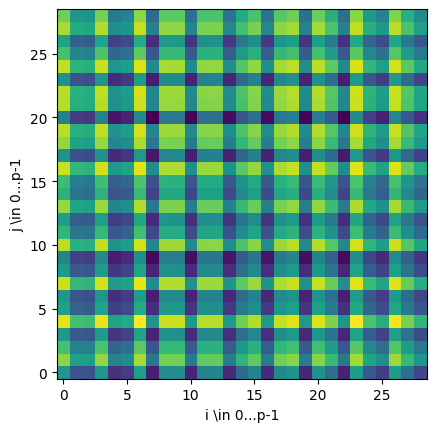

In [32]:
# Preactivation of a first-layer neuron over a grid of all possible inputs
p= params.p

digits = t.cartesian_prod(t.arange(p, device=device), t.arange(p, device=device))

x_left = F.one_hot(digits[:,0], num_classes=p).float()
x_right = F.one_hot(digits[:,1], num_classes=p).float()
x = t.cat([x_left, x_right], dim=1)
h = (model.net[1](model.net[0](x)))

img = h[:,10].reshape(p,p).detach().cpu().numpy()                # transpose so (i,j) matches (x,y)
plt.figure()
plt.imshow(img, origin='lower',
           extent=[-0.5, p-0.5, -0.5, p-0.5], interpolation='none')
plt.gca().set_aspect('equal', 'box')
plt.xlabel('i \in 0...p-1'); plt.ylabel('j \in 0...p-1')
#plt.colorbar(label='value')
plt.show()

Yay, it works!

In [33]:
def get_acts_lbls(model: nn.Module, layer: nn.Module, loader: DataLoader, device: str ='cpu') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Saves the model activations at the specified layer when we run the dataloader through the model, along with corresponding labels.

    model  : your trained nn.Module
    layer  : sub-module whose output you want (e.g. model.hidden)

    Returns:
    acts: (N, hidden_dim) float32 numpy array of model activations
    left: (N,) int32 numpy array
    right: (N,) int32 numpy array
    y_sum: (N,) int32 numpy array
    """
    model.eval().to(device)
    acts, y_sum, left, right = [], [], [], []

    h = layer.register_forward_hook(lambda _, __, out: acts.append(out.detach().cpu()))

    with t.no_grad():
        for xb, yb, d_pair in loader:                     # d_pair = (left, right)
            model(xb.to(device))
            y_sum.append(yb)                              # (d1+d2) % 10
            left.append(d_pair[:,0])                      # left-digit ID
            right.append(d_pair[:,1])                     # right-digit ID

    h.remove()
    return (t.cat(acts).detach().cpu().numpy(),
            t.argmax(t.cat(y_sum), dim=1).detach().cpu().numpy(),
            t.cat(left).detach().cpu().numpy(),
            t.cat(right).detach().cpu().numpy())

In [34]:
# Fresh data loader over the training set incl. labels.
probe_loader = DataLoader(
    TensorDataset(x_train, y_train, pairs[idx_tr]),  # include digit pairs
    batch_size = len(x_train),
    shuffle     = False)          # <--- important

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [36]:
# Next three cells: Train linear probe to predict left digit, right digit, sum of digits from activations.

train_act, sum_train, left_train, right_train = get_acts_lbls(model, model.net[1], probe_loader)

#scaler = StandardScaler().fit(train_act)
#X = scaler.transform(train_act)

X = train_act

probe_sum  = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, sum_train)
probe_left = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, left_train)
probe_right = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, right_train)

print("sum-digit probe acc :", accuracy_score(sum_train,  probe_sum.predict(X)))
print("left-digit probe acc:", accuracy_score(left_train, probe_left.predict(X)))
print("right-digit probe acc:", accuracy_score(right_train, probe_right.predict(X)))

sum-digit probe acc : 0.09523809523809523
left-digit probe acc: 1.0
right-digit probe acc: 1.0


In [37]:
train_act, sum_train, left_train, right_train = get_acts_lbls(model, model.net[2], probe_loader)

#scaler = StandardScaler().fit(train_act)
#X = scaler.transform(train_act)

X = train_act

probe_sum  = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, sum_train)
probe_left = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, left_train)
probe_right = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, right_train)

print("sum-digit probe acc :", accuracy_score(sum_train,  probe_sum.predict(X)))
print("left-digit probe acc:", accuracy_score(left_train, probe_left.predict(X)))
print("right-digit probe acc:", accuracy_score(right_train, probe_right.predict(X)))

sum-digit probe acc : 1.0
left-digit probe acc: 1.0
right-digit probe acc: 1.0


In [38]:
train_act, sum_train, left_train, right_train = get_acts_lbls(model, model.net[3], probe_loader)

#scaler = StandardScaler().fit(train_act)
#X = scaler.transform(train_act)

X = train_act

probe_sum  = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, sum_train)
probe_left = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, left_train)
probe_right = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, right_train)

print("sum-digit probe acc :", accuracy_score(sum_train,  probe_sum.predict(X)))
print("left-digit probe acc:", accuracy_score(left_train, probe_left.predict(X)))
print("right-digit probe acc:", accuracy_score(right_train, probe_right.predict(X)))

sum-digit probe acc : 1.0
left-digit probe acc: 0.17006802721088435
right-digit probe acc: 0.1683673469387755


# 2. Interpret eNTK eigenvectors

## 2.1. Indicators*

Used to make heat maps; we'll take their inner product with NTK eigenvectors or the equivalent.

In [13]:
def build_indicators(labels: t.Tensor, p: int):
    """
    labels : (N, 2) int array
             labels[:,0] = left digit (0-9)
             labels[:,1] = right digit (0-9)

    returns dict of {name: (N,) binary indicator}
    and     dict of {name: (N,10) one-hot matrix}  # for left/right/sum
    """
    left  = labels[:, 0]
    right = labels[:, 1]
    N     = len(labels)

    # --- A. atomic digit identity -----------------------------------------
    onehot = lambda v: np.eye(p, dtype=bool)[v]          # (N,p)

    left_onehot   = onehot(left)                          # (N,p)
    right_onehot  = onehot(right)

    # --- B. task-direct indicators ----------------------------------------
    sum_modp     = (left + right) % p
    sum_onehot    = onehot(sum_modp)

    carry_bit     = (left + right) >= p                  # (N,)
    same_parity   = (left % 2) == (right % 2)            # (N,)

    # --- C. low-order structure ------------------------------------------
    left_parity   = (left  % 2 == 1)                      # (N,)
    right_parity  = (right % 2 == 1)                      # (N,)
    same_digit    = left == right                         # (N,)

    # --- package ----------------------------------------------------------
    binary = {
        'carry'        : carry_bit,
        'same_parity'  : same_parity,
        'left_parity'  : left_parity,
        'right_parity' : right_parity,
        'same_digit'   : same_digit,
    }
    onehots = {
        'left_digit'   : left_onehot,    # each column k → “left digit = k”
        'right_digit'  : right_onehot,
        'sum_digit'    : sum_onehot,
    }
    return binary, onehots

In [14]:
binary, onehots = build_indicators(pairs.cpu().numpy(), params.p)

In [15]:
def fourier_cols(vals: np.ndarray, p: int) -> np.ndarray:
  """
  Build [cos(2π k val/p), sin(2π k val/p)] stacked column-wise.
  Return float32 array (N, floor(p//2), 2).
  """
  v = vals % p
  cols = []
  for k in range(1, p//2+1):
    ang = 2 * np.pi * k * v / p
    cols.append(np.stack((np.cos(ang), np.sin(ang)), axis=-1))  # (N, 2)
  F = np.stack(cols, axis=1).astype(np.float32)  # (N, floor(p//2), 2)
  return F


def build_fourier_features(labels: np.ndarray, p: int):
  """
  labels: (N,2) int array
  p     : modulus (odd)

  Returns: dict of real Fourier features:
    'n', 'm', 'sum', 'diff', '2n', '2m': (N, floor(p//2), 2)
    'readout': (N, p, floor(p//2), 2)
  """
  feats: Dict[str, np.ndarray] = {}

  left = labels[:, 0]
  right = labels[:, 1]

  # --- First-layer preactivation features ---------------------------------
  feats['n'] = fourier_cols(left, p)              #(N, floor(p//2), 2)
  feats['m'] = fourier_cols(right,p)

  # --- First-layer activation features ------------------------------------
  sum_mod  = (left + right) % p
  diff_mod = (left - right) % p
  feats['sum'] = fourier_cols(sum_mod, p)
  feats['diff'] = fourier_cols(diff_mod, p)
  feats['2n'] = fourier_cols(2 * left, p)
  feats['2m'] = fourier_cols(2 * right, p)

  # --- Second-layer preactivation features --------------------------------
  R = np.empty((labels.shape[0], p, p//2, 2))
  for q in range(p):
    R[:, q, :, :] = fourier_cols((sum_mod - q), p)
  feats['readout'] = R

  return feats

In [16]:
feats = build_fourier_features(pairs.cpu().numpy(), params.p)

## 2.2 Kernel and disentanglement algorithm.

### 2.2.1. Kernels*

In [17]:
# Dictionary of per-layer eNTK's

entk = empirical_ntk_by_layer(model.to(device), X.to(device), X.to(device))

In [18]:
# For our toy model there are two per-layer eNTK's, we can store them like so. Each shape (N,N,C,C)

entk_0 = entk['net.0']
entk_3 = entk['net.3']

In [19]:
# Also we can compute the full eNTK by summing them if we want.
vals = list(entk.values())
entk_full = t.zeros_like(vals[0])
for K in vals:
  entk_full += K

### 2.2.2. Eigendecomposition *

For **a(ny) kernel from above** we can compute the top eigenvalues/eigenvectors.

In [20]:
#eigvals, eigvecs = eig_decompose(entk_0[:,:,0,0], topk=200)
eigvals, eigvecs = eig_decompose(entk_0.diagonal(dim1=2, dim2=3).mean(-1), topk=200)

Text(0, 0.5, 'log(eigenvalue)')

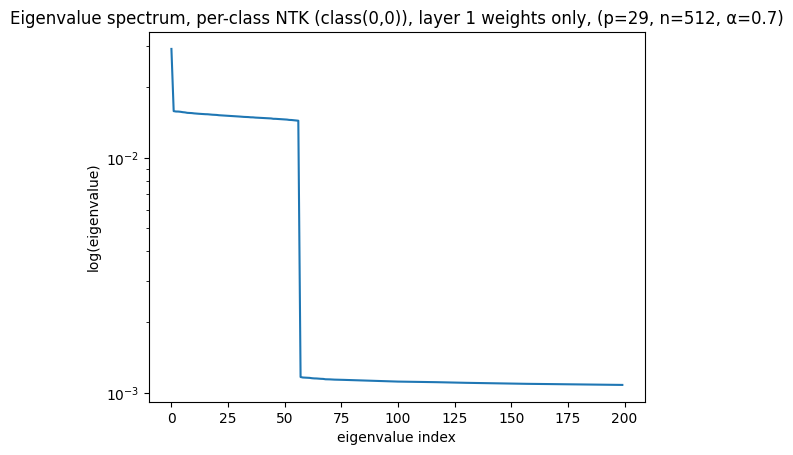

In [21]:
plt.plot(eigvals[:200].detach().cpu().numpy())
plt.yscale('log')
plt.title("Eigenvalue spectrum, per-class NTK (class(0,0)), layer 1 weights only, (p=29, n=512, α=0.7)")
plt.xlabel("eigenvalue index")
plt.ylabel("log(eigenvalue)")

### 2.2.3. Distentanglement

... then for **a(ny) block of eigenvectors inside one of the eigenvalue cliffs**, we can see if we can rotate them to line up with Fourier modes.

In [22]:
c1 = eigvecs[:, 1:57]  # First cliff. Shape: [841, 56]

#### Two-stage graph smoothness

The following works to completely disentangle the first cliff of 56 Fourier modes.

In [23]:
p=29

In [24]:
@t.no_grad()
def phase_insensitive_corr(cols: t. Tensor, binary_indicators: np.ndarray) -> np.ndarray:
  """
  Inputs:
    cols: shape (N,k) t.Tensor
    binary_indicators: shape (N,K,2) pair of indicators from binary_indicator function above (for sin k, cos k)

  Outputs:
    shape (K,k) thing that we plot in the heatmap.
  """
  A = cols / (cols.norm(dim=0, keepdim=True) + 1e-12)
  F = t.from_numpy(binary_indicators).to(A.device, A.dtype)
  F = F / (t.linalg.norm(F, dim=0, keepdim=True) + 1e-12)
  H = (F.permute(2,1,0) @ A).norm(dim=0)
  return H.cpu().numpy()

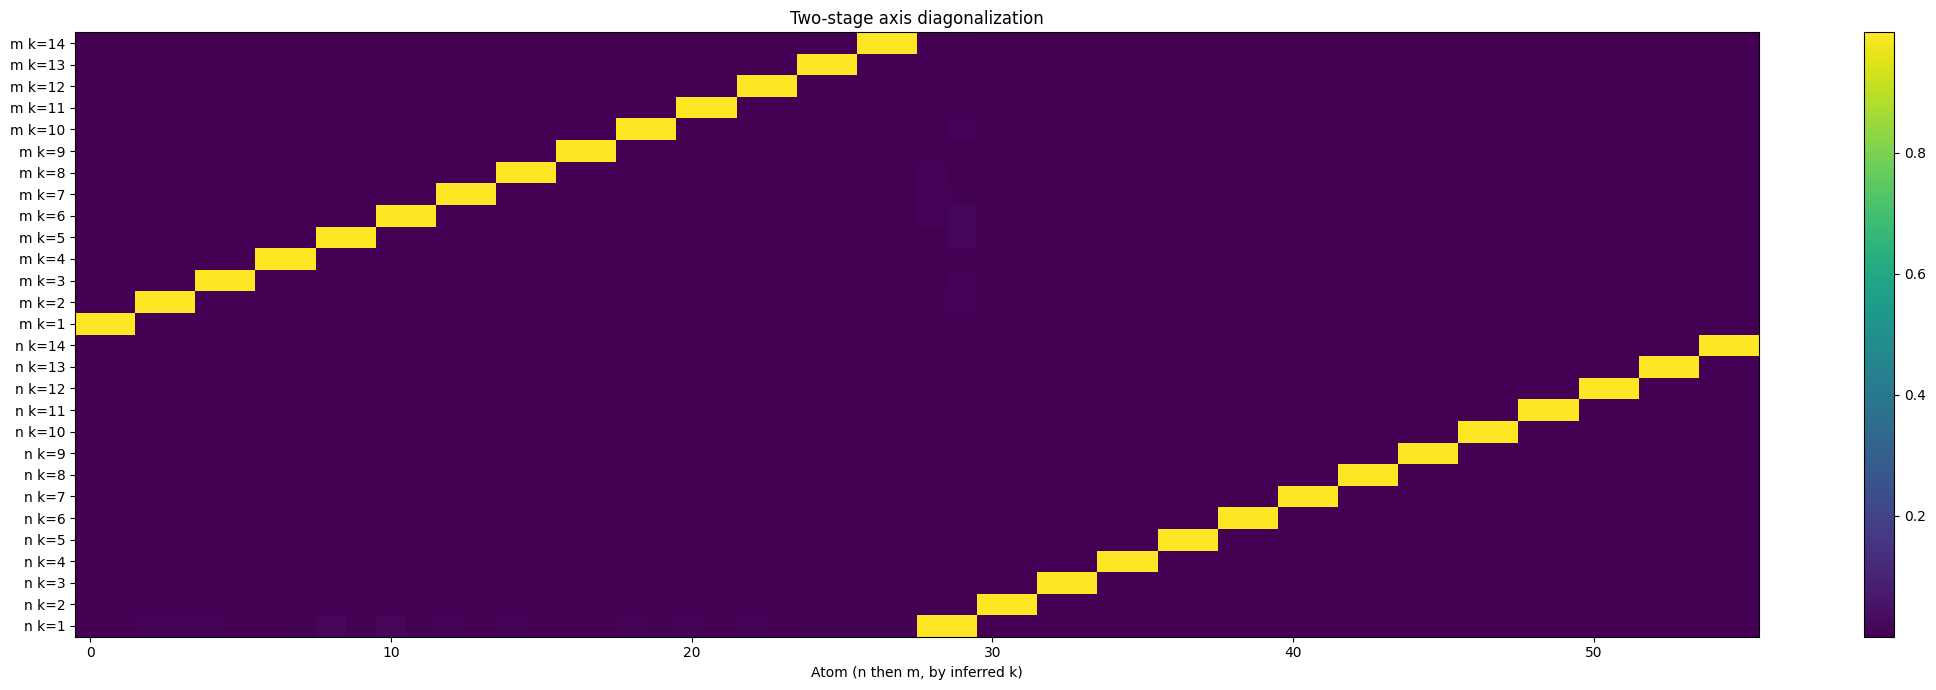

In [25]:
Ln, Lm = axis_laplacians_pxp(p)
U = two_stage_axis_diagonalization(c1, Ln.to(device), Lm.to(device))

# --- 4) Plot stacked n/m heatmaps (phase-insensitive, for evaluation) -----

Hn = phase_insensitive_corr(U, feats['n'])              # (K,56)
Hm = phase_insensitive_corr(U, feats['m'])              # (K,56)
stacked = np.vstack([Hn, Hm])

plt.figure(figsize=(22,7))
plt.imshow(stacked, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar()
Khalf = Hn.shape[0]
yt = [f"n k={i+1}" for i in range(Khalf)] + [f"m k={i+1}" for i in range(Khalf)]
plt.yticks(range(stacked.shape[0]), yt)
plt.xlabel("Atom (n then m, by inferred k)"); plt.title("Two-stage axis diagonalization")
plt.tight_layout(); plt.show()

# Optional: quick diagnostic—axis separation
#plt.figure(figsize=(5,5))
#plt.scatter(en, em, s=20, alpha=0.8)
#plt.xlabel("Rayleigh(L_n)"); plt.ylabel("Rayleigh(L_m)")
#plt.title("Per-atom axis energies (lower=axis-invariant)")
#plt.tight_layout(); plt.show()

#### Scratchwork: old graph laplacian. IGNORE THIS

This was an earlier attempt that "sort of" looked like it worked but required ordering columns manually ... not necessarily much better than ordering SDL columns manually! The above approach is better and actually works

In [26]:
def build_graph_laplacian_from_kernel(K: t.Tensor) -> t.Tensor:
  """
  Given a kernel K, return a (positive,) symmetrized version of it
  with the diagonal replaced by the negative sum over the rest of the row.
  This object is called the "combinatorial Laplacian".
  """
  device, dtype = K.device, K.dtype

  # Build a weighted adjacency matrix from the kernel
  W = K.clone()
  W.fill_diagonal_(0)
  W = t.relu(W)

  # Symmetrize
  W = 0.5 * (W + W.T)

  # Make row sums 0
  d = W.sum(dim=1)
  D = t.diag(d)
  L = D-W
  return L

In [27]:
@t.no_grad()
def smooth_rotation(
    J: t. Tensor,                     # shape: (N,k) that we want to rotate
    L_graph: t.Tensor                 # shape: (N,N)
) -> tuple[t.Tensor, t.Tensor]:
  """
  Rotate J to line up with the smoothest directions in L_graph.

  Returns:
    A: (N,k) smooth orthonormal basis in sample space (atoms)
    S: (k,k) codes s.t. A @ S = J
  """
  N,k = J.shape
  device, dtype = J.device, J.dtype

  # Orthonormalize J
  Q, R = t.linalg.qr(J, mode='reduced')  # Q is the orthonormalized version of J w/(k) orthonormal columns.

  # Compute and symmetrize q^T *L * Q.
  L_sub = Q.T @ L_graph @ Q              # shape (k,N) * (N,N) * (N,k) = shape (k,k)
  L_sub = 0.5 * (L_sub + L_sub.T)

  eigvals, eigvecs = t.linalg.eigh(L_sub)# ascending

  A = Q @ eigvecs                        # shape (N,k)* (k,k) = shape (N,k).
  S = eigvecs.T @ R

  return A,S

In [28]:
L = build_graph_laplacian_from_kernel(entk_0[:,:,0,0])
A,S = smooth_rotation(c1, L_graph=L)

In [29]:
def phase_corr(A, F):
  """
  Inputs:
    A: (N,k)    atoms from above
    F: (N,k,2)  sin/cos atoms from binary indicator fn.
  Normalize A, F and return the normalized correlation matrix
  of A with each Fourier family (norm over sin + cos at a given frequency)
  """
  #A = t.from_numpy(A)
  F = t.from_numpy(F).to(device)
  A = A / (1e-12 + t.linalg.norm(A, dim=0))
  F = F / (1e-12 + t.linalg.norm(F, dim=0))
  H = (F.permute(2,1,0) @ A).norm(dim=0) # (k,k)
  return H

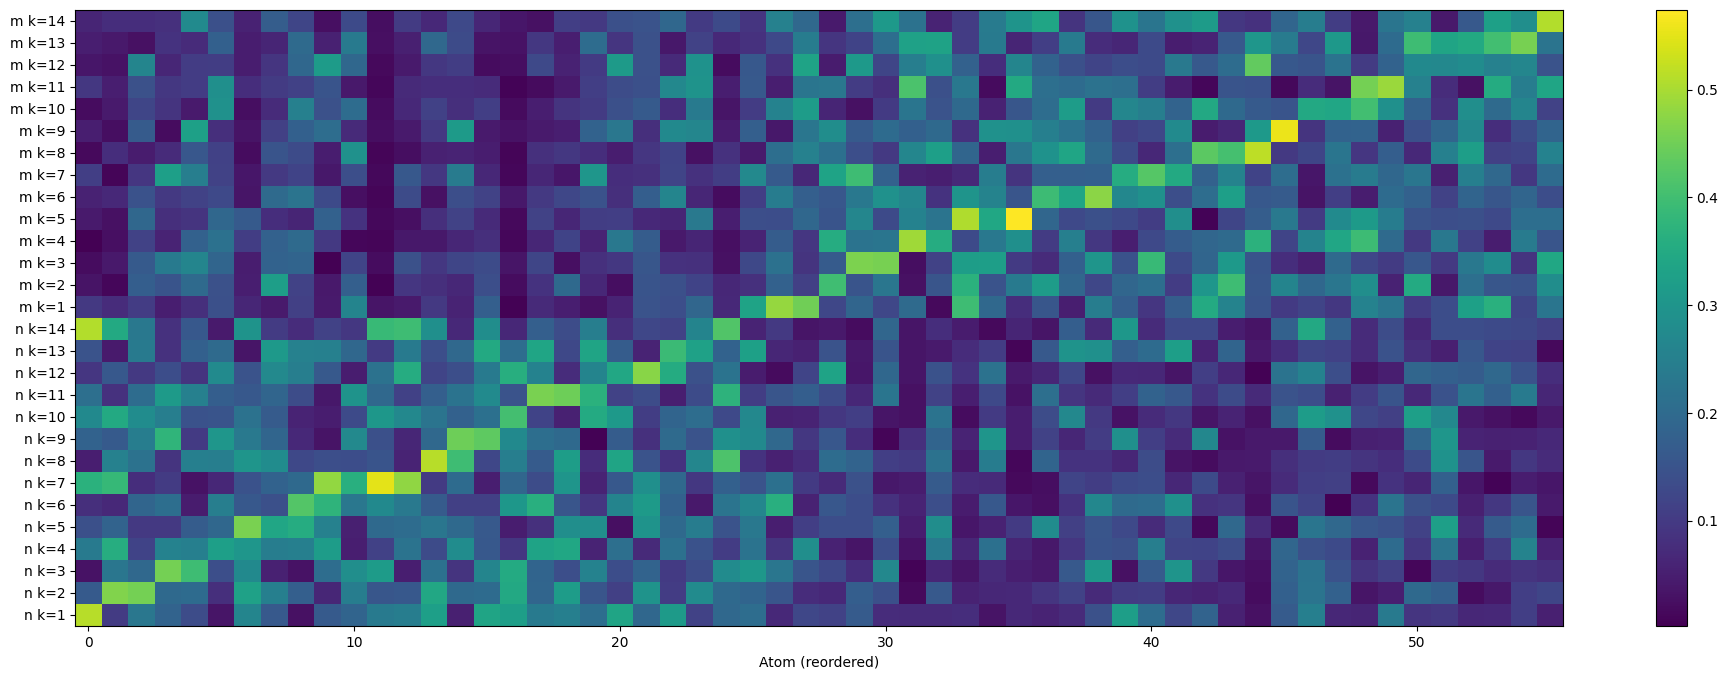

In [33]:
F_n = t.from_numpy(feats['n']).float().to(A.device)   # (N,K,2)
F_m = t.from_numpy(feats['m']).float().to(A.device)   # (N,K,2)

Hn = phase_corr(A, feats['n'])  # (K,k)
Hm = phase_corr(A, feats['m'])  # (K,k)

# For each of the k columns, report whether its strongest correlation with anything is in 'm' or 'n'.
best_is_n = (Hn.max(dim=0).values >= Hm.max(dim=0).values)  # (k,)

# For each of the k columns, return the corresponding index among whichever of 'm' or 'n' features where the correlation is strongest.
best_k = t.where(best_is_n, Hn.argmax(dim=0), Hm.argmax(dim=0))  # (k,)

# =================

# reorder atoms: first all n-atoms by frequency, then m-atoms by frequency
idx_n = t.nonzero(best_is_n, as_tuple=True)[0]
idx_m = t.nonzero(~best_is_n, as_tuple=True)[0]
order_n = idx_n[best_k[idx_n].argsort()]
order_m = idx_m[best_k[idx_m].argsort()]
order = t.cat([order_n, order_m], dim=0)

A_ord = A[:, order]
Hn_ord = Hn[:, order].cpu().numpy()
Hm_ord = Hm[:, order].cpu().numpy()

#Hn_ord = Hn.cpu().numpy()
#Hm_ord = Hm.cpu().numpy()


# visualize stacked (n on top, m below)
import matplotlib.pyplot as plt
plt.figure(figsize=(24,8))
stacked = np.vstack([Hn_ord, Hm_ord])  # (2K, k)
plt.imshow(stacked, cmap='viridis', origin='lower', aspect='auto')
plt.yticks(
    list(range(stacked.shape[0])),
    [f"n k={i+1}" for i in range(Hn_ord.shape[0])] + [f"m k={i+1}" for i in range(Hm_ord.shape[0])]
)
plt.xlabel("Atom (reordered)"); plt.colorbar(); plt.show()

## 2.3. Heatmaps

The code to make the plots is fine but the plots themselves are mislabeled. Regenerate the plots and manually fix titles for clean figures.

### 2.3.1. Sum/left/right digit

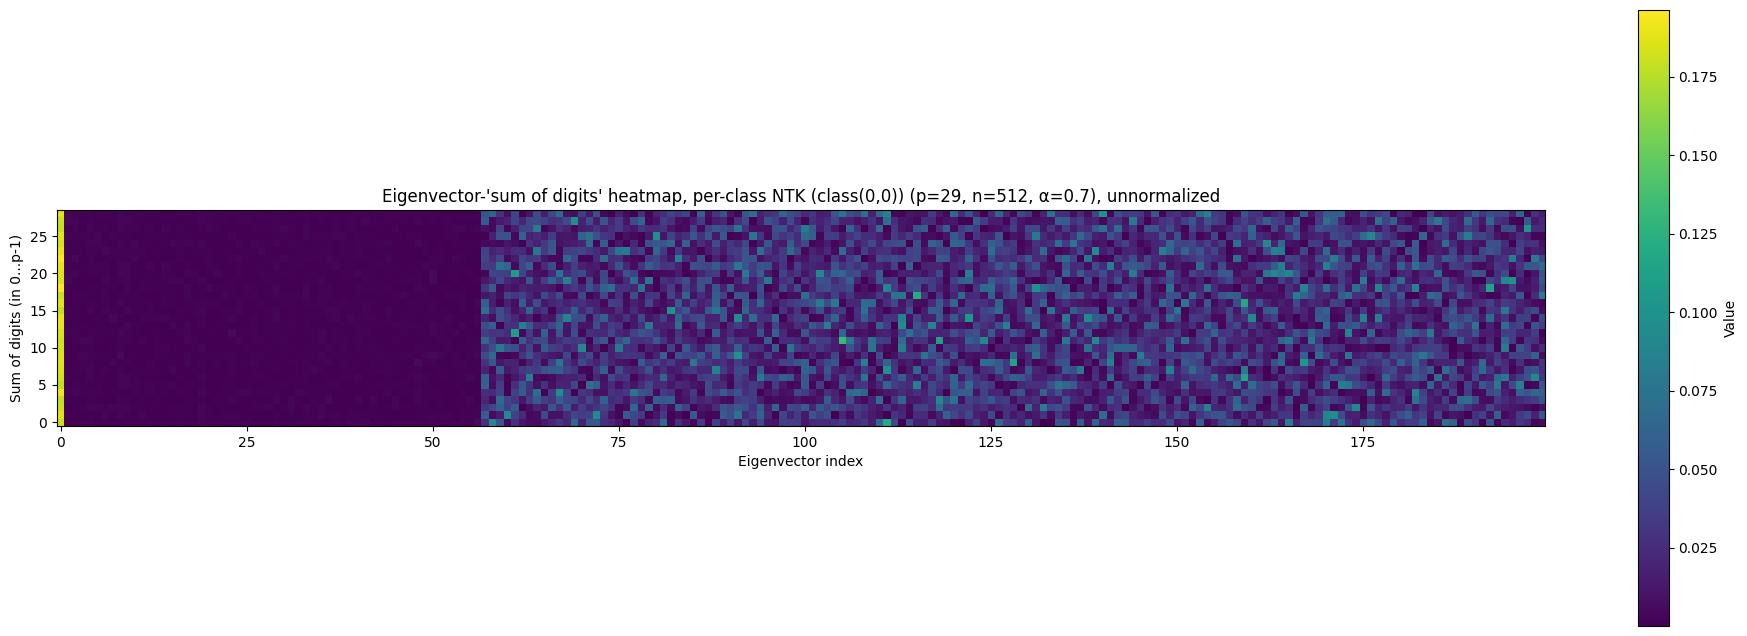

In [26]:
z_flat = t.from_numpy(onehots['sum_digit']).float().to(device)

z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N*C, C), each column (appearances of that feature across the dataset) normalied to 1
eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (NC, k), each column (eigenvector) normalized to 1

heatmap = (z_flat.T @ eigvecs).detach().cpu().numpy()
heatmap = np.abs(heatmap)

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))

plt.figure(figsize=(24, 8))
plt.imshow(heatmap, cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Show color scale
plt.title("Eigenvector-'sum of digits' heatmap, per-class NTK (class(0,0)) (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("Sum of digits (in 0...p-1)")
plt.show()

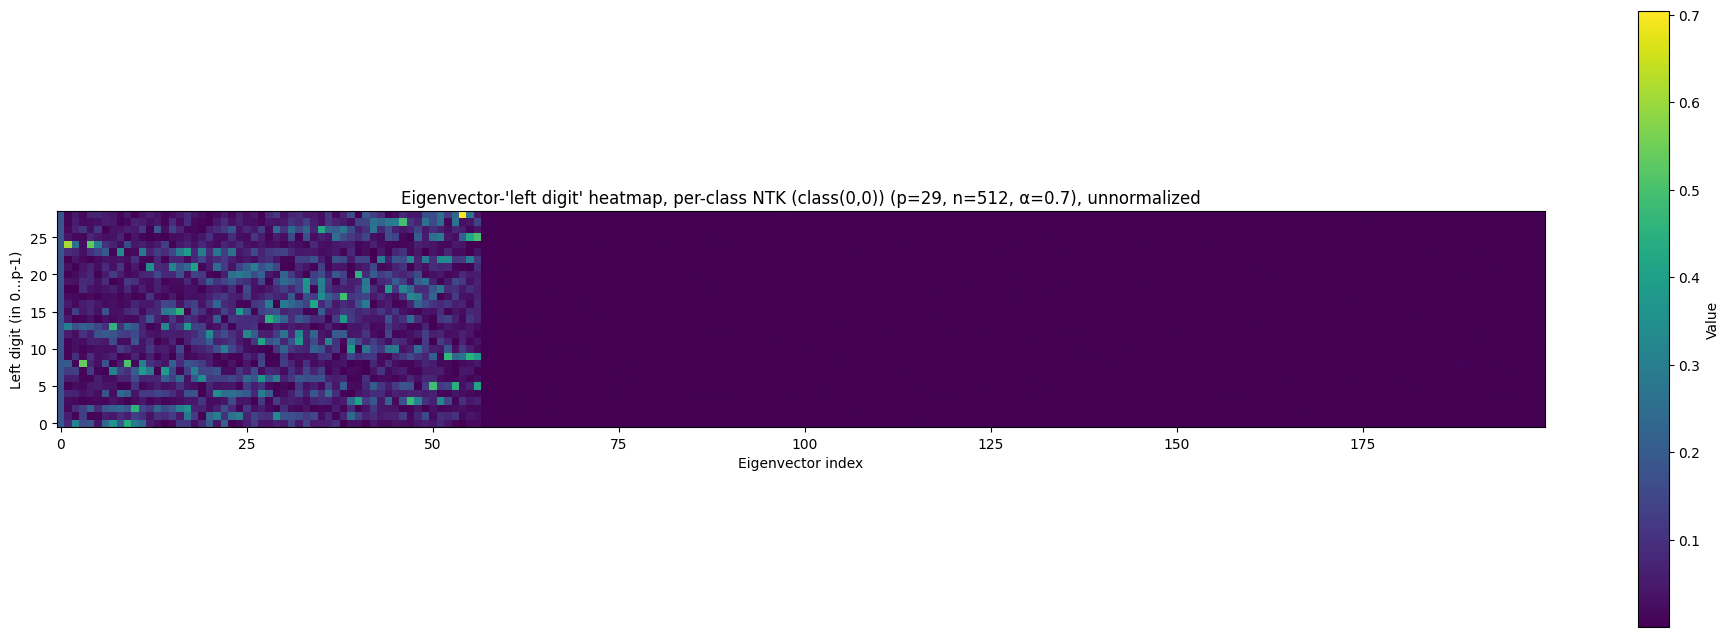

In [27]:
z_flat = t.from_numpy(onehots['left_digit']).float().to(device)

z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N*C, C), each column (appearances of that feature across the dataset) normalied to 1
eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (NC, k), each column (eigenvector) normalized to 1

heatmap = (z_flat.T @ eigvecs).detach().cpu().numpy()
heatmap = np.abs(heatmap)

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))

plt.figure(figsize=(24, 8))
plt.imshow(heatmap, cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Show color scale
plt.title("Eigenvector-'left digit' heatmap, per-class NTK (class(0,0)) (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("Left digit (in 0...p-1)")
plt.show()

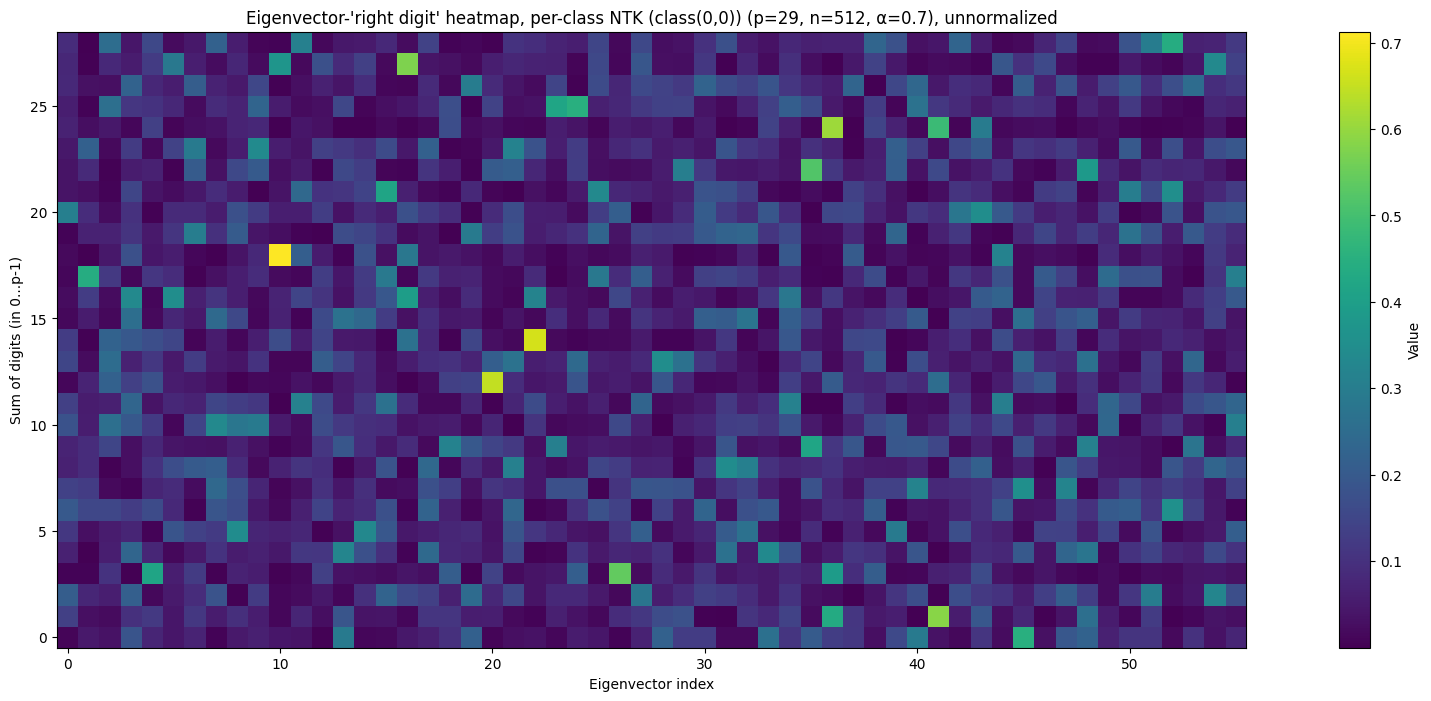

In [55]:
z_flat = t.from_numpy(onehots['right_digit']).float().to(device)

z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N*C, C), each column (appearances of that feature across the dataset) normalied to 1
eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (NC, k), each column (eigenvector) normalized to 1

heatmap = (z_flat.T @ eigvecs).detach().cpu().numpy()
heatmap = np.abs(heatmap)

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))

plt.figure(figsize=(24, 8))
plt.imshow(heatmap, cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Show color scale
plt.title("Eigenvector-'right digit' heatmap, per-class NTK (class(0,0)) (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("Sum of digits (in 0...p-1)")
plt.show()

### 2.3.2. Fourier features

/tmp/ipython-input-2149079249.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)
  heatmap = (z_flat.T @ eigvecs)                                     # (2, floor(C/2), k)


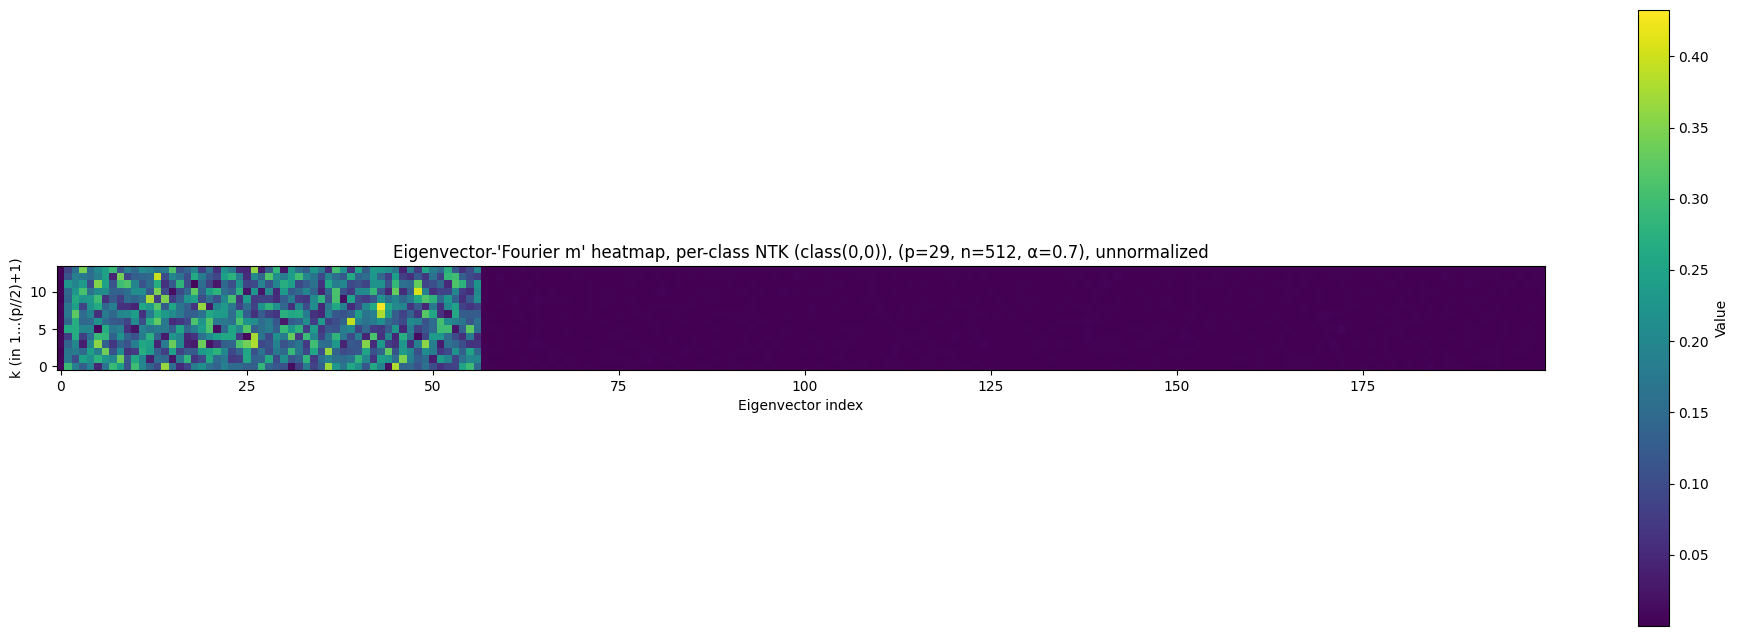

In [28]:
  N = 841
  C = 29

  z_flat = t.from_numpy(feats['m']).float().to(device)

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N, floor(C/2), 2), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (N, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T @ eigvecs)                                     # (2, floor(C/2), k)
  heatmap = heatmap.norm(dim=0).detach().cpu().numpy()

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))


plt.figure(figsize=(24, 8))
plt.imshow(heatmap, cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Shw color scale
plt.title("Eigenvector-'Fourier m' heatmap, per-class NTK (class(0,0)), (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("k (in 1...(p//2)+1)")
plt.show()

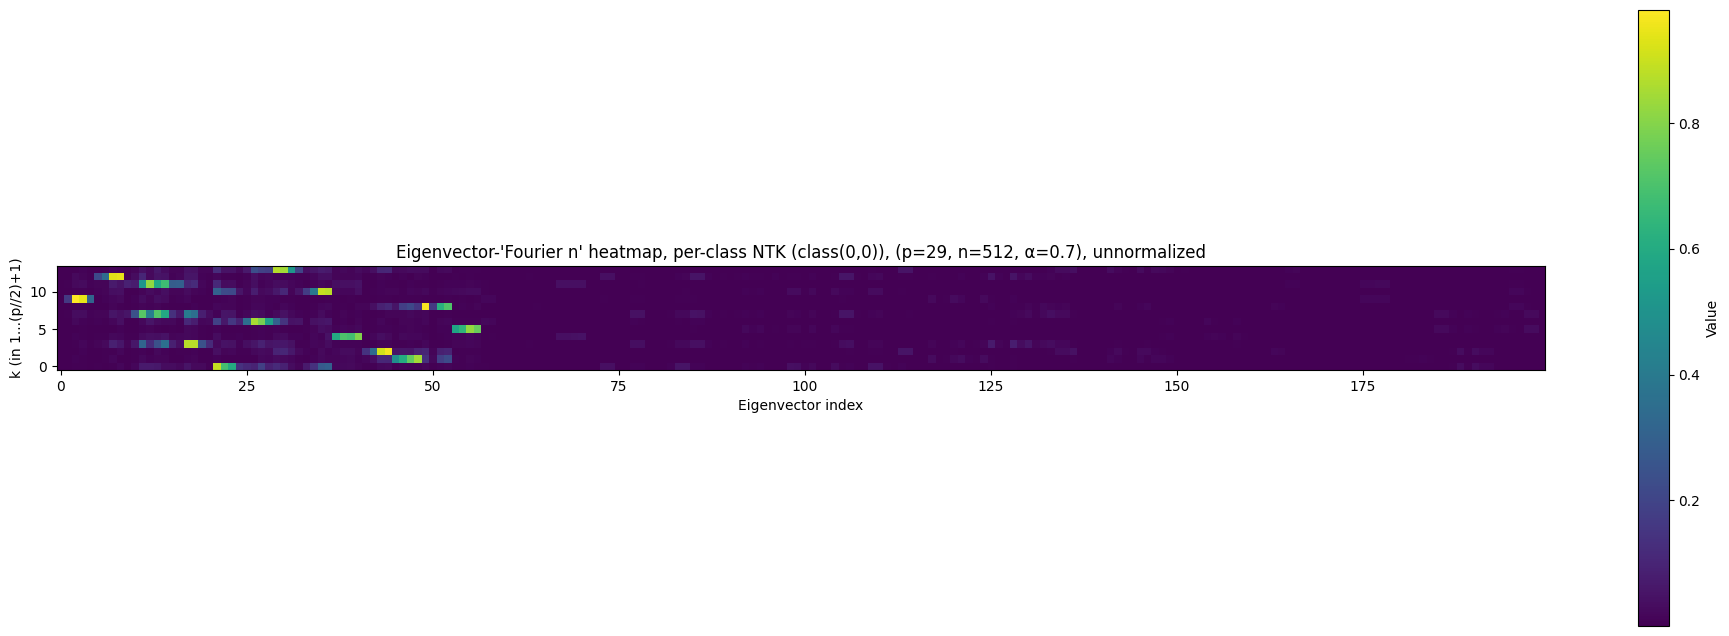

In [42]:
  N = 841
  C = 29

  z_flat = t.from_numpy(feats['n']).float().to(device)

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N, floor(C/2), 2), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (N, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T @ eigvecs)                                     # (2, floor(C/2), k)
  heatmap = heatmap.norm(dim=0).detach().cpu().numpy()

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))


plt.figure(figsize=(24, 8))
plt.imshow(heatmap, cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Show color scale
plt.title("Eigenvector-'Fourier n' heatmap, per-class NTK (class(0,0)), (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("k (in 1...(p//2)+1)")
plt.show()

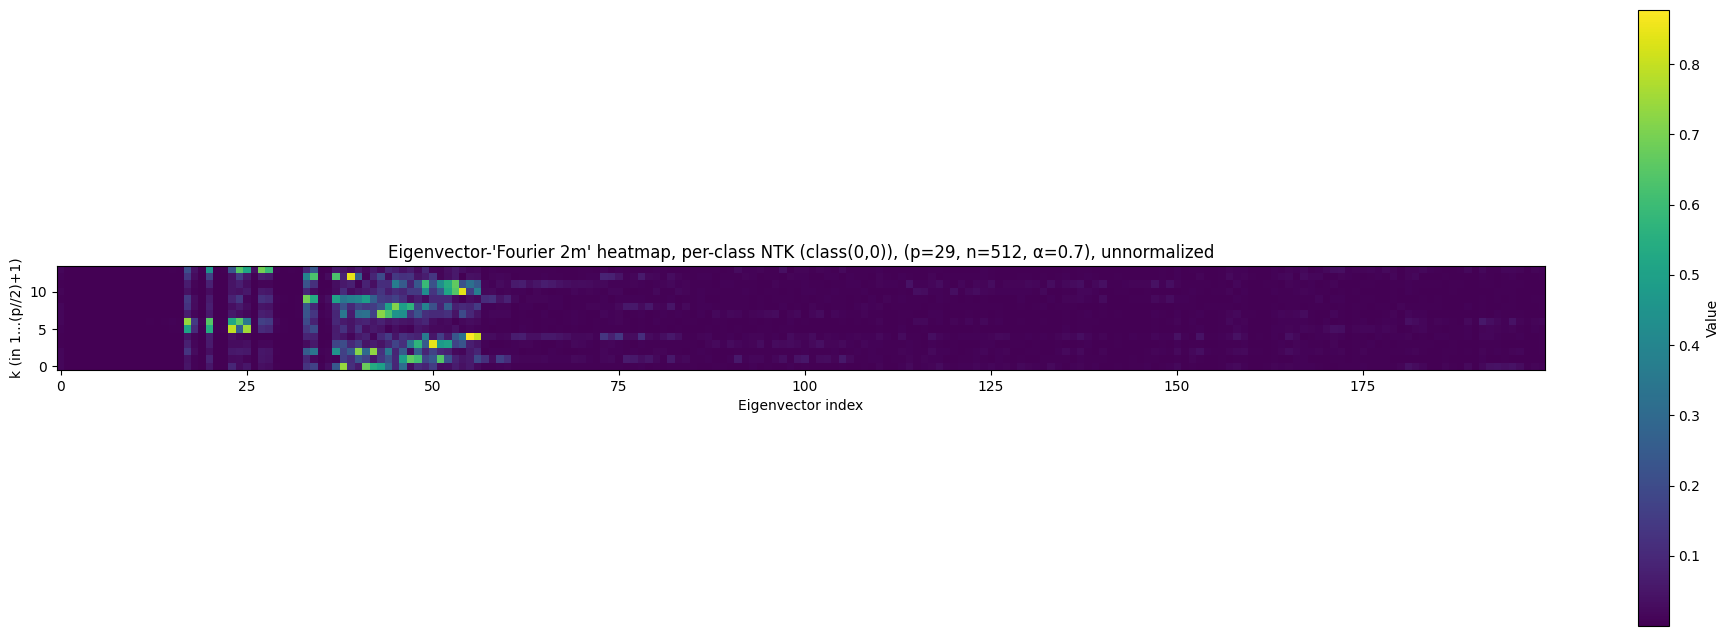

In [35]:
  N = 841
  C = 29

  z_flat = t.from_numpy(feats['2m']).float().to(device)

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N, floor(C/2), 2), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (N, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T @ eigvecs)                                     # (2, floor(C/2), k)
  heatmap = heatmap.norm(dim=0).detach().cpu().numpy()

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))


plt.figure(figsize=(24, 8))
plt.imshow(heatmap, cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Show color scale
plt.title("Eigenvector-'Fourier 2m' heatmap, per-class NTK (class(0,0)), (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("k (in 1...(p//2)+1)")
plt.show()

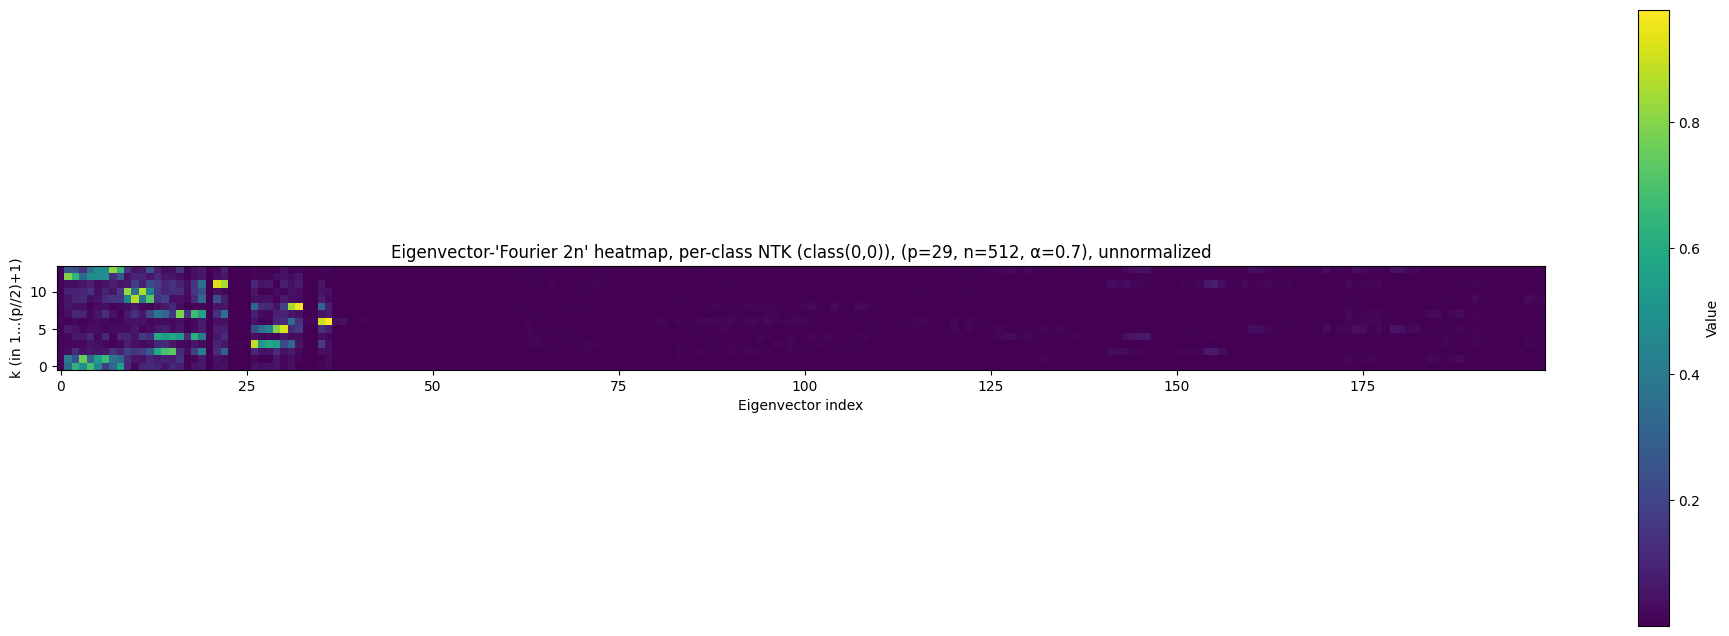

In [36]:
  N = 841
  C = 29

  z_flat = t.from_numpy(feats['2n']).float().to(device)

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N, floor(C/2), 2), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (N, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T @ eigvecs)                                     # (2, floor(C/2), k)
  heatmap = heatmap.norm(dim=0).detach().cpu().numpy()

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))


plt.figure(figsize=(24, 8))
plt.imshow(heatmap, cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Show color scale
plt.title("Eigenvector-'Fourier 2n' heatmap, per-class NTK (class(0,0)), (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("k (in 1...(p//2)+1)")
plt.show()

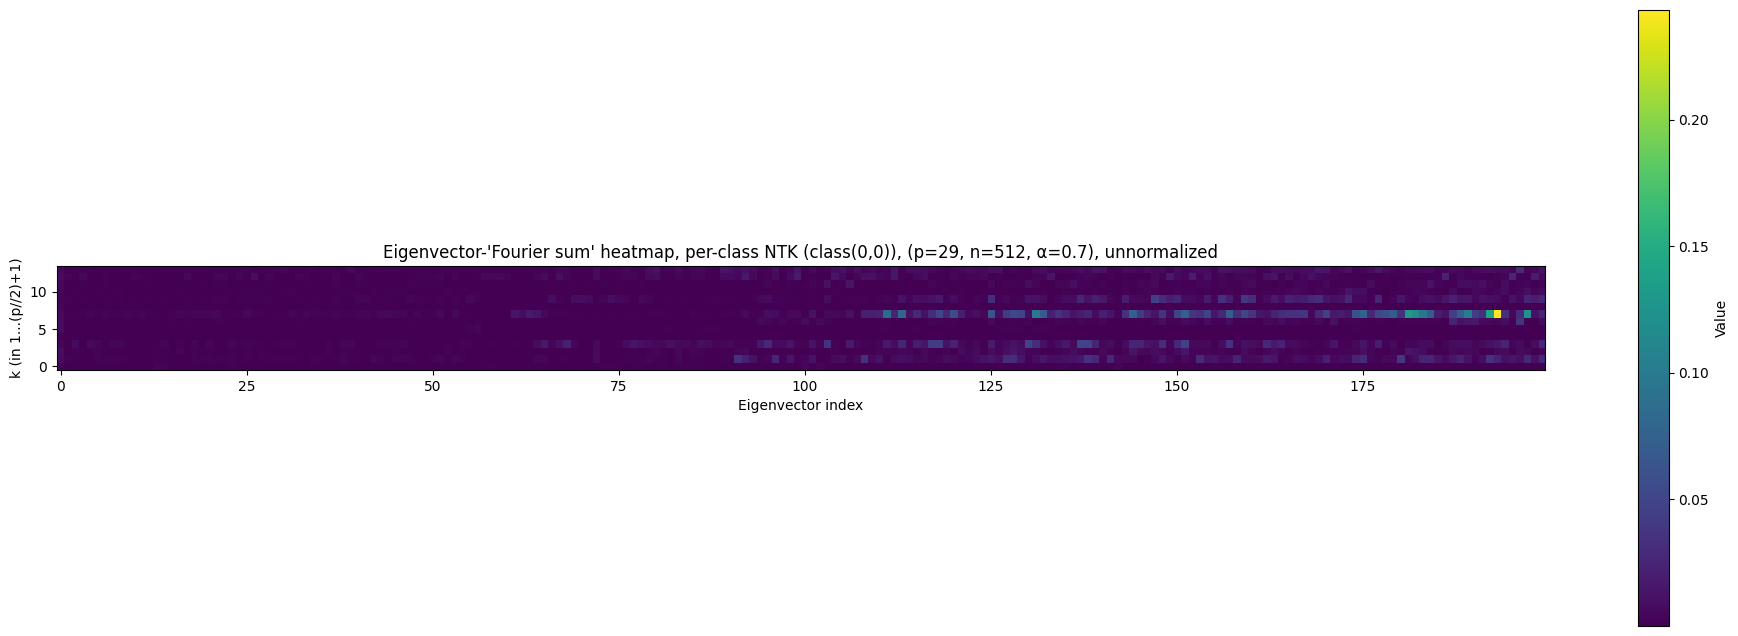

In [46]:
  N = 841
  C = 29

  z_flat = t.from_numpy(feats['sum']).float().to(device)

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N, floor(C/2), 2), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (N, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T @ eigvecs)                                     # (2, floor(C/2), k)
  heatmap = heatmap.norm(dim=0).detach().cpu().numpy()

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))


plt.figure(figsize=(24, 8))
plt.imshow(heatmap, cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Show color scale
plt.title("Eigenvector-'Fourier sum' heatmap, per-class NTK (class(0,0)), (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("k (in 1...(p//2)+1)")
plt.show()

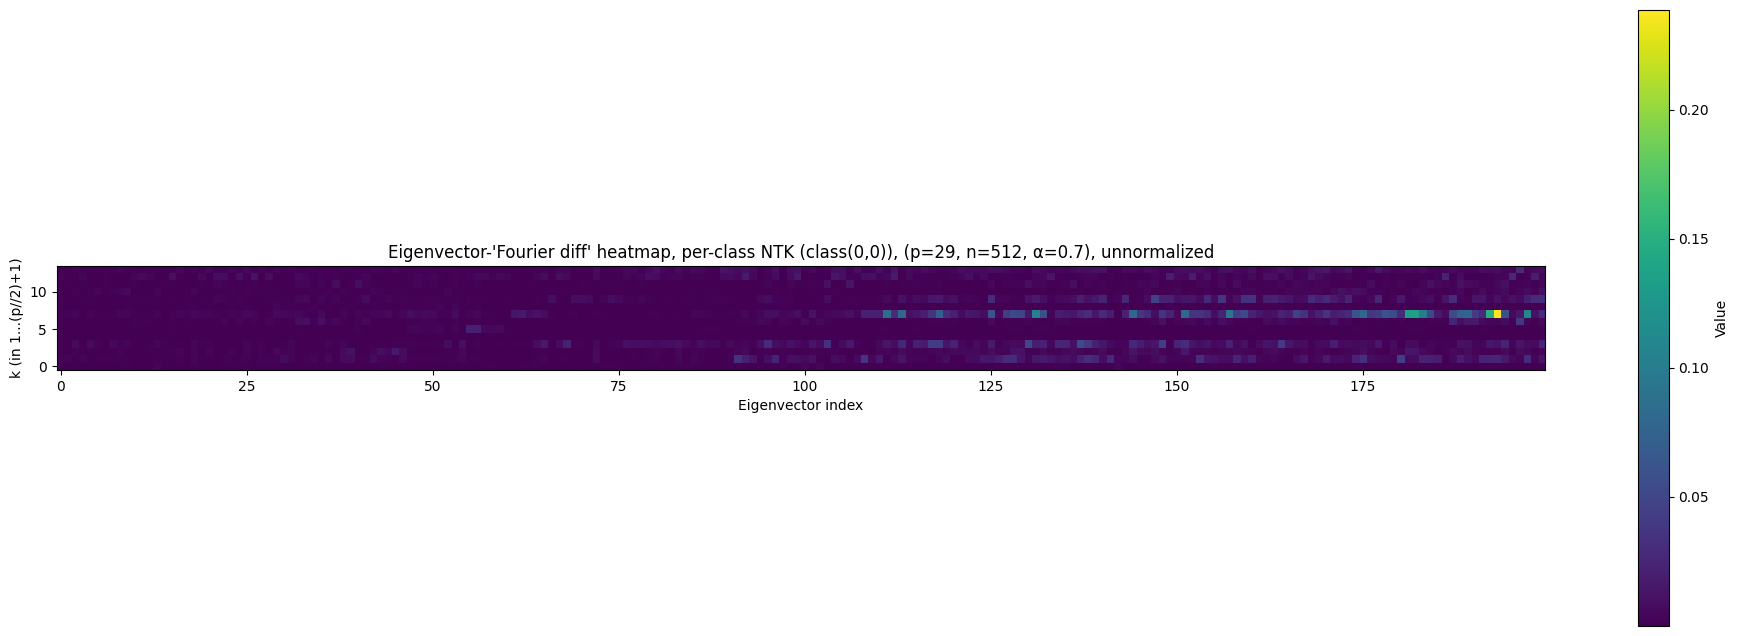

In [47]:
  N = 841
  C = 29

  z_flat = t.from_numpy(feats['diff']).float().to(device)

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N, floor(C/2), 2), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (N, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T @ eigvecs)                                     # (2, floor(C/2), k)
  heatmap = heatmap.norm(dim=0).detach().cpu().numpy()

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))


plt.figure(figsize=(24, 8))
plt.imshow(heatmap, cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Show color scale
plt.title("Eigenvector-'Fourier diff' heatmap, per-class NTK (class(0,0)), (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("k (in 1...(p//2)+1)")
plt.show()

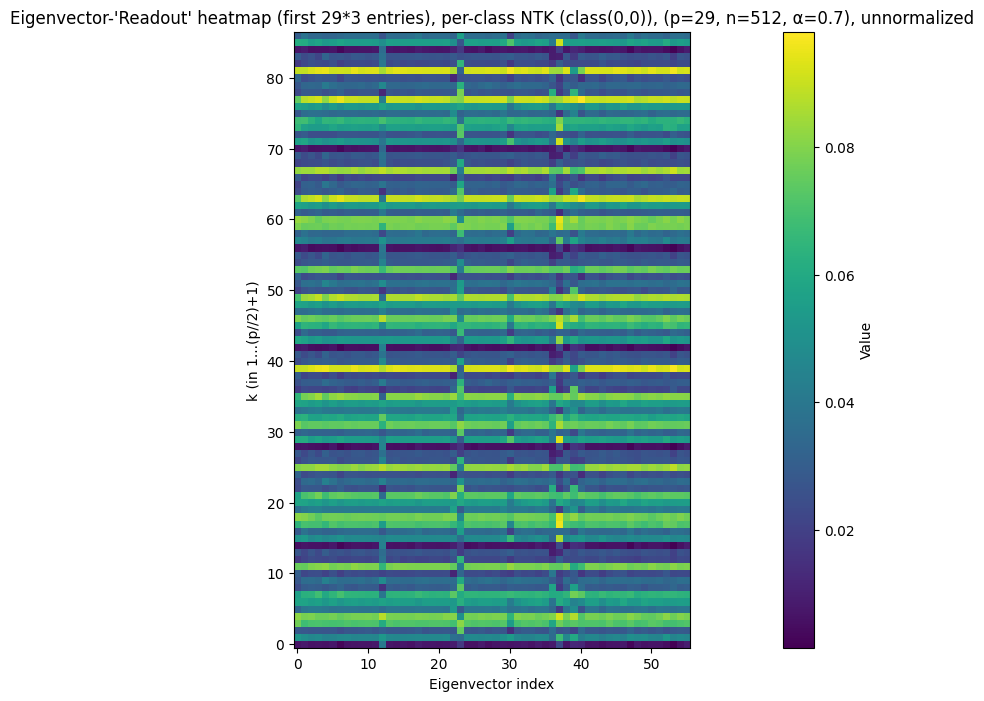

In [76]:
  N, p_floor, P, _ = feats['readout'].shape

  z_flat = t.from_numpy(feats['readout']).reshape(N, p_floor*P, 2).float().to(device)

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N, p*p_floor, 2), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (N, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T[:,:29*3,:] @ eigvecs).detach().cpu().numpy()             # (2, p_pfloor,, k)
  heatmap = np.abs(heatmap)

  #heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))


plt.figure(figsize=(24, 8))
plt.imshow(heatmap.sum(axis=0), cmap='viridis', origin='lower')
plt.colorbar(label="Value")  # Show color scale
plt.title("Eigenvector-'Readout' heatmap (first 29*3 entries), per-class NTK (class(0,0)), (p=29, n=512, α=0.7), unnormalized")
plt.xlabel("Eigenvector index")
plt.ylabel("k (in 1...(p//2)+1)")
plt.show()